In [1]:
import numpy as np
import librosa
from librosa.display import waveshow, specshow
import torchaudio
import torch
from torchaudio import transforms as T 
from torchaudio import functional as F 
from matplotlib import pyplot as plt

from pitch_tracker.utils.dataset import extract_melspectrogram_feature


In [16]:
def plot_spectrogram_from_feature(S: np.ndarray, sample_rate:int, scale:str='linear', n_mels:int=108, **stft_params):
    if len(S.shape) == 2:
        S = np.expand_dims(S, axis=0)
        print(S.shape)
    # Apply FFT & Calculate the Magnitude Spectrum
    y_axis=None
    S_log = S
    if scale == 'mel':
        S_log = librosa.power_to_db(S, ref=np.max)
        y_axis = 'mel'
    elif scale == 'linear':
        S_log = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        y_axis = 'linear'


    num_channels, num_mels, num_frames = S.shape
    figure, axes = plt.subplots(nrows=num_channels, ncols=1)

    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        # axes[c].plot(frequency[:num_frequency_bins], magnitude_spectrum[c,:num_frequency_bins])
        im = specshow(S_log[c], sr=sample_rate, x_axis='time', y_axis=y_axis, ax=axes[c])
        # axes[c].grid(True)
        axes[c].label_outer()
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        # else:
        #     axes[c].set_ylabel(f"Mel")
    figure.suptitle("Spectrogram")
    figure.colorbar(im, ax=axes, format="%+2.0f dB")

    plt.show(block=False)



In [17]:
audio_path = '../medleydb/medleydb/data/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav'
metadata = torchaudio.info(audio_path)
song_duration = metadata.num_frames/metadata.sample_rate # in seconds
m,s = divmod(song_duration, 60)
print(metadata)
print(f'Song duration: {song_duration:.2f}s ({m:.0f}m{s:.0f}s)')

AudioMetaData(sample_rate=44100, num_frames=7811926, num_channels=2, bits_per_sample=16, encoding=PCM_S)
Song duration: 177.14s (2m57s)


In [18]:
#load audio
signal, sample_rate = torchaudio.load(audio_path)

# cut audio if any
offset = 0
dur = None

if dur:
    signal = signal[:,offset:offset+(dur*sample_rate)]

# convert to mono
signal_mono = torch.mean(signal, dim=0)


In [19]:
hop_length = 512
n_fft = 1024
win_length = n_fft
n_mels = 128#108-21+1
sample_rate = 44100

melspectrogram_extractor = T.MelSpectrogram(
    sample_rate=sample_rate,
    hop_length=hop_length,
    n_fft=n_fft,
    win_length=win_length,
    pad_mode='constant',
    center=True,
    f_min=librosa.midi_to_hz(21),
    f_max=None,
    n_mels=n_mels,
    power=2.0,
    norm="slaney",
)

mel_feature_torchaudio = melspectrogram_extractor(signal)

mel_feature_librosa = librosa.feature.melspectrogram(
    y=signal.numpy(),
    sr=sample_rate,
    hop_length=hop_length,
    n_fft=n_fft,
    win_length=win_length,
    pad_mode='constant',
    center=True,
    fmin=librosa.midi_to_hz(21),
    fmax=None,
    n_mels=n_mels,
    power=2.0,
    htk=True)

In [20]:
print(
    f'Shape of melspectrogram feature {mel_feature_librosa.shape}, where:\n'
    f'channel: {mel_feature_librosa.shape[0]}\n'
    f'n_mels: {mel_feature_librosa.shape[1]}\n'
    f'n_frames: {mel_feature_librosa.shape[2]}\n'
)
print(mel_feature_torchaudio.shape)

Shape of melspectrogram feature (2, 128, 15258), where:
channel: 2
n_mels: 128
n_frames: 15258

torch.Size([2, 128, 15258])


In [21]:
# How is n_frames calculated?
# the sample_rate argument in librosa is for plotting the time axis
n_samples = song_duration * sample_rate 
# is the same to:
n_channels, n_samples = signal.shape

n_frames = n_samples / n_fft / (hop_length/n_fft)
n_frames = int(n_frames) + 1 # number of frame
print(f'Number of frame: {n_frames}')

Number of frame: 15258


In [22]:
mel_spec = extract_melspectrogram_feature(signal_mono.numpy(), n_fft, hop_length, n_mels)
print(mel_spec.shape)

(128, 15258)


(1, 128, 15258)


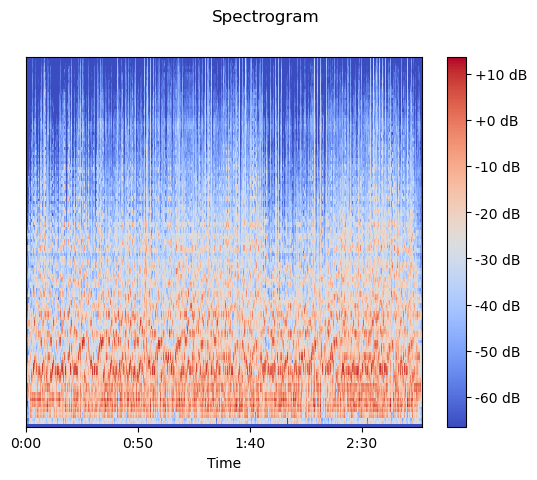

In [23]:
plot_spectrogram_from_feature(mel_spec, sample_rate, scale=None)

In [ ]:
import os
import pandas as pd
import torch
from pitch_tracker.utils.files import save_pickle, load_pickle

In [ ]:
out_obj_path = '../content/test/test_mel_feature.pkl'
out_npy_path = '../content/test/test_mel_feature.npy'
out_torch_path = '../content/test/test_mel_feature.torch'
save_pickle(mel_feature_torchaudio, out_obj_path)
np.save(out_npy_path, mel_feature_torchaudio.numpy())
torch.save(mel_feature_torchaudio, out_torch_path)

In [ ]:
S_pickle = load_pickle(out_obj_path)
S_np = np.load(out_npy_path)
S_torch = torch.load(out_torch_path)
print(S_pickle.shape)
print(S_np.shape)

torch.Size([2, 128, 15258])
(2, 128, 15258)
